#Model Training

In [21]:
# General Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, roc_curve, ConfusionMatrixDisplay)
from imblearn.combine import SMOTETomek

# Machine Learning Models
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping


In [5]:


# Load the initial features and target
X = pd.read_csv("/content/X_initial.csv")
y = pd.read_csv("/content/y_initial.csv").squeeze()  # Convert to Series for compatibility

# Load the train-test split data
X_train = pd.read_csv("/content/X_train.csv")
X_test = pd.read_csv("/content/X_test.csv")
y_train = pd.read_csv("/content/y_train.csv").squeeze()  # Convert to Series
y_test = pd.read_csv("/content/y_test.csv").squeeze()    # Convert to Series

# Load the resampled training data
X_train_resampled = pd.read_csv("/content/X_train_resampled.csv")
y_train_resampled = pd.read_csv("/content/y_train_resampled.csv").squeeze()  # Convert to Series

# Verify data loading
print("Initial features and target shapes:")
print(f"X: {X.shape}, y: {y.shape}")

print("\nTrain-test split shapes:")
print(f"X_train: {X_train.shape}, X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}, y_test: {y_test.shape}")

print("\nResampled training data shapes:")
print(f"X_train_resampled: {X_train_resampled.shape}, y_train_resampled: {y_train_resampled.shape}")


Initial features and target shapes:
X: (45211, 45), y: (45211,)

Train-test split shapes:
X_train: (36168, 45), X_test: (9043, 45)
y_train: (36168,), y_test: (9043,)

Resampled training data shapes:
X_train_resampled: (62164, 45), y_train_resampled: (62164,)


##NN

In [30]:

def build_and_train_neural_network(X_train, y_train):
    """
    Builds and trains a Neural Network.

    Parameters:
        X_train (pd.DataFrame): Training features.
        y_train (pd.Series): Training target variable.

    Returns:
        nn_model: Trained Neural Network model.
        scaler: Fitted StandardScaler instance.
    """
    # Scale features for Neural Network
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)

    # Build Neural Network
    nn_model = Sequential([
        Dense(192, activation='relu', input_shape=(X_train_scaled.shape[1],)),
        Dropout(0.2),
        Dense(128, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])

    # Compile the Neural Network
    nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Train the Neural Network
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = nn_model.fit(X_train_scaled, y_train, validation_split=0.2, epochs=50,
                       batch_size=64, callbacks=[early_stopping])

    return nn_model, scaler

In [42]:
# Assuming X_train and y_train are preprocessed and ready
nn_model, scaler, history = build_and_train_neural_network(X_train, y_train)

# Scale the test set using the fitted scaler
X_test_scaled = scaler.transform(X_test)

# Make predictions on the test set
y_prob = nn_model.predict(X_test_scaled)
y_pred = (y_prob > 0.5).astype("int32")  # Default threshold of 0.5

# Evaluate the model
from sklearn.metrics import classification_report, roc_auc_score

print("Classification Report:")
print(classification_report(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_prob))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
453/453 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.6586 - loss: 0.5639 - val_accuracy: 0.8305 - val_loss: 0.3666
Epoch 2/50
453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8074 - loss: 0.3867 - val_accuracy: 0.8203 - val_loss: 0.3675
Epoch 3/50
453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8061 - loss: 0.3789 - val_accuracy: 0.8275 - val_loss: 0.3480
Epoch 4/50
453/453 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8176 - loss: 0.3461 - val_accuracy: 0.8066 - val_loss: 0.3800
Epoch 5/50
453/453 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8138 - loss: 0.3420 - val_accuracy: 0.8203 - val_loss: 0.3560
Epoch 6/50
453/453 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8223 - loss: 0.3377 - val_accuracy: 0.8214 - val_loss: 0.3484
Epoch 7/50
453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8166 - loss: 0.3447 - val_accuracy: 0.8181 - val_loss: 0.3511
Epoch 8/50
453/453 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8245 - loss: 0.3232 - val_accuracy: 0.

##RF

In [12]:
def train_random_forest(X_train, y_train):
    """
    Trains a Random Forest classifier.

    Parameters:
        X_train (pd.DataFrame): Training features.
        y_train (pd.Series): Training target variable.

    Returns:
        rf_model: Trained Random Forest model.
    """
    rf_model = RandomForestClassifier(random_state=42)
    rf_model.fit(X_train, y_train)
    return rf_model


In [35]:
 rf_model = train_random_forest(X_train_resampled, y_train_resampled)

KeyboardInterrupt: 

#Model Evaluation

In [10]:

def evaluate_model(model, X_test, y_test, scaler=None, model_type='rf'):
    """
    Evaluates the model and prints classification report and ROC-AUC score.

    Parameters:
        model: The trained model (Random Forest or Neural Network).
        X_test (pd.DataFrame): Test features.
        y_test (pd.Series): Test target variable.
        scaler: Fitted StandardScaler instance (for Neural Network).
        model_type (str): Type of model ('rf' for Random Forest, 'nn' for Neural Network).
    """
    if model_type == 'rf':
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
    elif model_type == 'nn':
        X_test_scaled = scaler.transform(X_test)
        y_pred_proba = model.predict(X_test_scaled)
        y_pred = (y_pred_proba > 0.5).astype(int)

    print(f"{model_type.upper()} Classification Report:")
    print(classification_report(y_test, y_pred))
    print(f"{model_type.upper()} ROC-AUC Score:", roc_auc_score(y_test, y_pred_proba))
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
NN Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94      7985
           1       0.55      0.54      0.55      1058

    accuracy                           0.89      9043
   macro avg       0.75      0.74      0.74      9043
weighted avg       0.89      0.89      0.89      9043

NN ROC-AUC Score: 0.9127167195580559


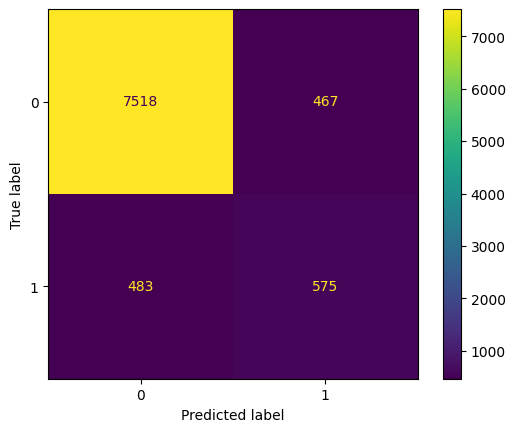

In [41]:

  evaluate_model(nn_model, X_test, y_test, scaler=scaler, model_type='nn')

RF Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.95      0.94      7985
           1       0.59      0.51      0.55      1058

    accuracy                           0.90      9043
   macro avg       0.76      0.73      0.75      9043
weighted avg       0.90      0.90      0.90      9043

RF ROC-AUC Score: 0.9207566053079204


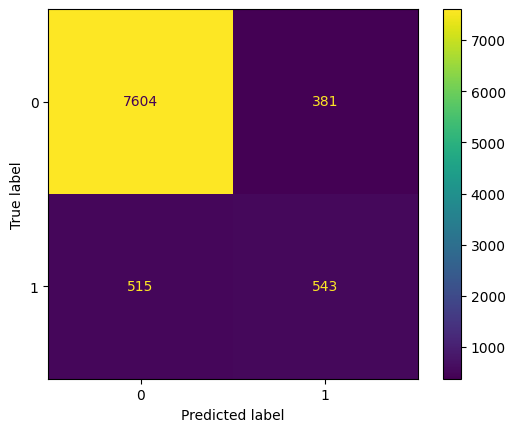

In [14]:
evaluate_model(rf_model, X_test, y_test, model_type='rf')

#Fine Tuning

##NN

In [ ]:
def hyperparameter_tuning(X_train, y_train):
    """
    Performs hyperparameter tuning using KerasTuner.
    """
    def build_tuned_model(hp):
        model = Sequential([
            Dense(hp.Int('units_layer1', min_value=64, max_value=256, step=32), activation='relu', input_dim=X_train_scaled.shape[1]),
            Dropout(hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)),
            Dense(hp.Int('units_layer2', min_value=32, max_value=128, step=32), activation='relu'),
            Dropout(hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)),
            Dense(1, activation='sigmoid')
        ])
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall', 'AUC'])
        return model

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)

    tuner = RandomSearch(
        build_tuned_model,
        objective='val_accuracy',
        max_trials=10,
        executions_per_trial=1,
        directory='tuner_results',
        project_name='nn_hyperparam_tuning'
    )
    tuner.search(X_train_scaled, y_train, epochs=20, validation_split=0.2, callbacks=[EarlyStopping(patience=5)])
    best_hyperparameters = tuner.get_best_hyperparameters()[0]
    print("Best hyperparameters found:", best_hyperparameters.values)
    best_model = tuner.hypermodel.build(best_hyperparameters)
    return best_model, scaler

In [ ]:

    # Learning Rate Scheduler
    def scheduler(epoch, lr):
        if epoch < 10:
            return lr
        else:
            return lr * tf.math.exp(-0.1).numpy()

    lr_scheduler = LearningRateScheduler(scheduler)

In [ ]:
# Perform hyperparameter tuning
best_model, scaler = hyperparameter_tuning(X_train, y_train)

# Evaluate tuned model
final_accuracy = evaluate_neural_network(best_model, X_test, y_test, scaler)

print("Final Model Performance:")
print(f"Final Accuracy (Test): {final_accuracy:.4f}")

# Cross-Validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
accuracies = []

for train_index, test_index in skf.split(X, y):
        X_train_cv, X_test_cv = X.iloc[train_index], X.iloc[test_index]
        y_train_cv, y_test_cv = y.iloc[train_index], y.iloc[test_index]

        X_train_cv, y_train_cv = smote.fit_resample(X_train_cv, y_train_cv)
        model_cv, scaler_cv = build_and_train_neural_network(X_train_cv, y_train_cv, lr_scheduler=lr_scheduler)
        accuracy = evaluate_neural_network(model_cv, X_test_cv, y_test_cv, scaler_cv)
        accuracies.append(accuracy)

print(f"Cross-Validation Accuracy: {np.mean(accuracies):.4f}")

##RF

In [27]:
def fine_tune_random_forest(X_train, y_train):
    """
    Fine-tunes the Random Forest classifier using GridSearchCV.
    """
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20, 50],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 5],
        'max_features': ['sqrt', 'log2'],
        'bootstrap': [True, False]
    }
    rf = RandomForestClassifier(random_state=42)
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, scoring='roc_auc', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    return grid_search.best_estimator_, grid_search.best_params_




In [28]:
def feature_importance(rf_model, feature_names):
    """
    Plots the feature importance for the Random Forest model.
    """
    importances = rf_model.feature_importances_
    sorted_indices = importances.argsort()[::-1]
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(importances)), importances[sorted_indices])
    plt.xticks(range(len(importances)), feature_names[sorted_indices], rotation=90)
    plt.title('Feature Importance')
    plt.show()

In [29]:
print("Fine-tuning Random Forest...")
rf_best_model, best_params = fine_tune_random_forest(X_train_resampled, y_train_resampled)
print("Best Parameters:", best_params)

print("Evaluating the best model on test data...")
evaluate_model(rf_best_model, X_test, y_test, model_type='rf')

print("Plotting feature importance...")
feature_importance(rf_best_model, X.columns)

Fine-tuning Random Forest...


KeyboardInterrupt: 